In [12]:
import pymssql
import pandas as pd
import numpy as np
import mplfinance as mpf
from collections import defaultdict

In [13]:
def connect_sql():
    db_settings = {
        "host": "172.30.52.193",
        "port": 1433,
        "user": "sa",
        "password": "255089",
        "database": "ncudb",
        "charset": "utf8"
    }

    conn  = pymssql.connect(**db_settings)
    return conn

In [14]:
def get_data(company, start, end, cursor):
    command = f"""SELECT date, o, h, l, c, v, MA5, MA10
            FROM stock_price
            where stock_code = {company} AND date > '{start}' AND date < '{end}'"""
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()  
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    arr_df = pd.DataFrame(arr)
    arr_df['Date'] = pd.to_datetime(arr_df[0])
    arr_df = arr_df.sort_values(by="Date")
    arr_df = arr_df.drop(columns=[0]) # remove extra date column
    arr_df.set_index("Date",inplace=True)
    
    arr_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume','MA5','MA10']

    return arr_df

In [15]:
def get_turning_wave(company, start, end, cursor):
    command = f"""select end_date, end_date_price, trend
                from find_trend('{company}')
                WHERE end_date > '{start}' AND end_date < '{end}'
                ORDER BY end_date ASC
                """
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()  
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    df = pd.DataFrame(arr)
    df.columns = ['date', 'close_price', 'trend']
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    
    # 開始找轉折點 -> 從日期最大的找起
    df_result = pd.DataFrame()

    # 先取得第一個趨勢
    cur_trend = 0
    for idx in range(df['date'].size - 1, 0, -1):
        if df.loc[idx, 'trend'] != 0:
            cur_trend = df.loc[idx, 'trend']
            break

    cur_max_min = 0 # 根據當前趨勢，去暫存最大或最小收盤價 
    cur_start_day = np.nan
    for idx in range(df['date'].size - 1, -1, -1):
        # 趨勢轉變 跟 最後一筆時, 儲存資訊
        if (df.loc[idx, 'trend'] != 0 and df.loc[idx, 'trend'] != cur_trend) or idx == 0:
            # save
            df_tmp = pd.DataFrame([[cur_start_day, np.nan, cur_max_min, cur_trend]],
                   columns=['start_day', 'end_day', 'close_price', 'trend'])
            df_result = pd.concat([df_tmp, df_result])
            
            # reset
            cur_trend = df.loc[idx, 'trend']
            cur_max_min = 0
        
        if cur_trend == 1: # find max
            if df.loc[idx, 'close_price'] > cur_max_min:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
        else: # cur_tend == -1, find min
            if df.loc[idx, 'close_price'] < cur_max_min or cur_max_min == 0:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
    
    # reset index because the indices would all be zeros
    df_result.reset_index(drop=True, inplace=True)
    
    # 新增 end day
    df_result['end_day'] = df_result['start_day'].shift()
    # 因為第0筆沒有資料，直接放入最舊的日期
    df_result.loc[0, 'end_day'] = df.loc[0, 'date']
    
    return df_result

In [16]:
def find_patterns(min_max):
    patterns = defaultdict(list) # In order to append index easily
    # Find W Shape / Double Bottoms
    for i in range(5 ,len(min_max)):
        window = min_max.iloc[i - 5:i]

        if ((window.iloc[-1]['start_day'] - window.iloc[0]['start_day']).days) > 180:
            continue

        a, b, c, d, e = window['close_price'].iloc[0:5]

        # 雖然這邊頸線用中間峰值畫水平線，但為了找出比較符合的pattern，還是會比較兩點
        if b < c and d < c and abs(b - d) <= np.mean([b, d]) * 0.07 and a >= c:
            patterns['W'].append(window.index)

    # Find M Shape / Double Tops
    for i in range(5 ,len(min_max)):
        window = min_max.iloc[i - 5:i]

        if ((window.iloc[-1]['start_day'] - window.iloc[0]['start_day']).days) > 180:
            continue

        a, b, c, d, e = window['close_price'].iloc[0:5]

        # 雖然這邊頸線用中間峰值畫水平線，但為了找出比較符合的pattern，還是會比較兩點
        if b > c and d > c and abs(b - d) <= np.mean([b, d]) * 0.07 and a <= c:
            patterns['M'].append(window.index)
    # find ihs (inverted head and shoulders)
    # window size is 7 units
    for i in range(7, len(min_max)):
        window = min_max.iloc[i - 7:i]

        if ((window.iloc[-1]['start_day'] - window.iloc[0]['start_day']).days) > 180:
            continue

        a, b, c, d, e, f, g = window['close_price'].iloc[0:7]
        if d < b and d < c and d < e and d < f and b < c and f < e and abs(c - e) <= np.mean([c, e]) * 0.05:
            patterns['IHS'].append(window.index)

    # find hs (head and shoulders)
    # window size is 7 units
    for i in range(7, len(min_max)):
        window = min_max.iloc[i - 7:i]

        if ((window.iloc[-1]['start_day'] - window.iloc[0]['start_day']).days) > 180:
            continue

        a, b, c, d, e, f, g = window['close_price'].iloc[0:7]

        if d > b and d > c and d > e and d > f and b > c and f > e and abs(c - e) <= np.mean([c, e]) * 0.05:
            patterns['HS'].append(window.index)

    return patterns

In [17]:
def prepare_plot_data(df, patterns, type, turning_wave, result):
    
    # no data, assign empty obj
    if len(patterns[type]) == 0:
        result[type] = {}
        result[type]['turning_points'] = []
        result[type]['datepairs'] = []
        result[type]['intervals'] = []
        return

    
    # concat index of dots
    indicesList = []
    for indices in patterns[type]:
        indicesList.extend(indices) # use [extend] because we want to concat all of the list

    # for drawing all turning points of each pattern
    turning_points = []
    date = df.index.date
    for i in range(len(date)):
        if str(date[i]) in turning_wave.loc[indicesList, 'start_day'].to_string():
            turning_points.append(df['Close'][i])
        else :
            turning_points.append(np.nan)
    # print(turning_points)

    # for drawing lines of each pattern
    datepairs = []
    dot_amount = patterns[type][0].size # M,W 跟 HS,IHS圖形取的點數量不同
    for indices in patterns[type]:
        for j in range(0, dot_amount - 1):
            # print(indices[j],indices[j + 1])
            datepairs.append((turning_wave.loc[indices[j], 'start_day'], turning_wave.loc[indices[j + 1], 'start_day']))
    # print(datepairs)

    # for framing time interval with 2 vertical lines of each pattern
    # and for saving (date, price) tuple of necklines of each pattern
    #  要用mplfinance的alines 畫出來, 而alines每個點是一對tuple(date, price)
    intervals = []
    necklines = []
    for indices in patterns[type]:
        # -----intervals-----
        start_day = turning_wave.loc[indices[0], 'start_day']
        end_day = turning_wave.loc[indices[-1], 'start_day']
        intervals.append(start_day)
        intervals.append(end_day)

        # -----necklines-----
        # W M 用中間點的價錢  而date要橫跨圖形前後各一個時間點
        # IHS HS 用 c e 兩點  而date要橫跨圖形前後各一個時間點
        if type == 'W' or type =='M':
            price = turning_wave.loc[indices[2], 'close_price']
            # 因為一個圖形畫一個頸線, 所以用dict 包兩個 tuples
            necklines.append([(start_day, price), (end_day, price)])
        else:
            c_day = turning_wave.loc[indices[2], 'start_day']
            c_price = turning_wave.loc[indices[2], 'close_price']
            e_day = turning_wave.loc[indices[4], 'start_day']
            e_price = turning_wave.loc[indices[4], 'close_price']

            price_delta = e_price-c_price
            time_delta = pd.Timedelta(e_day-c_day).days
            slope = price_delta/time_delta

            time_delta = pd.Timedelta(c_day-start_day).days
            price_delta = slope*time_delta
            start_price = c_price-price_delta

            time_delta = pd.Timedelta(end_day-e_day).days
            price_delta = slope*time_delta
            end_price = e_price+price_delta

            necklines.append([(start_day, start_price), (end_day, end_price)])
        
    # print(intervals)
    # print(necklines)
    

    result[type] = {}
    result[type]['turning_points'] = turning_points
    result[type]['datepairs'] = datepairs
    result[type]['intervals'] = intervals
    result[type]['necklines'] = necklines
    # print(result)

In [18]:
def plot_pattern(type, df, plot_data, datepairs_turning_wave):
    if len(plot_data[type]['turning_points']) == 0:
        mpf.plot(df, type='candle', style='yahoo', mav = (5), volume = True, figsize=(100,30),
                    tlines = [dict(tlines=datepairs_turning_wave, tline_use='close', colors='b', linewidths=5, alpha=0.7)])
        mpf.show
        return
    
    apd = [mpf.make_addplot(plot_data[type]['turning_points'], type='scatter', markersize=200, marker='^', color = 'aqua')] 

    mpf.plot(df, type='candle', style='yahoo', mav = (5), volume = True, addplot = apd, figsize=(100,30),
                        tlines = [dict(tlines=datepairs_turning_wave, tline_use='close', colors='b', linewidths=5, alpha=0.7),
                            dict(tlines=plot_data[type]['datepairs'], tline_use='close', colors='r', linewidths=5, alpha=0.7)],
                        vlines = dict(vlines=plot_data[type]['intervals'], colors='c'),
                        alines = dict(alines=plot_data[type]['necklines'], colors='orange'))
    mpf.show

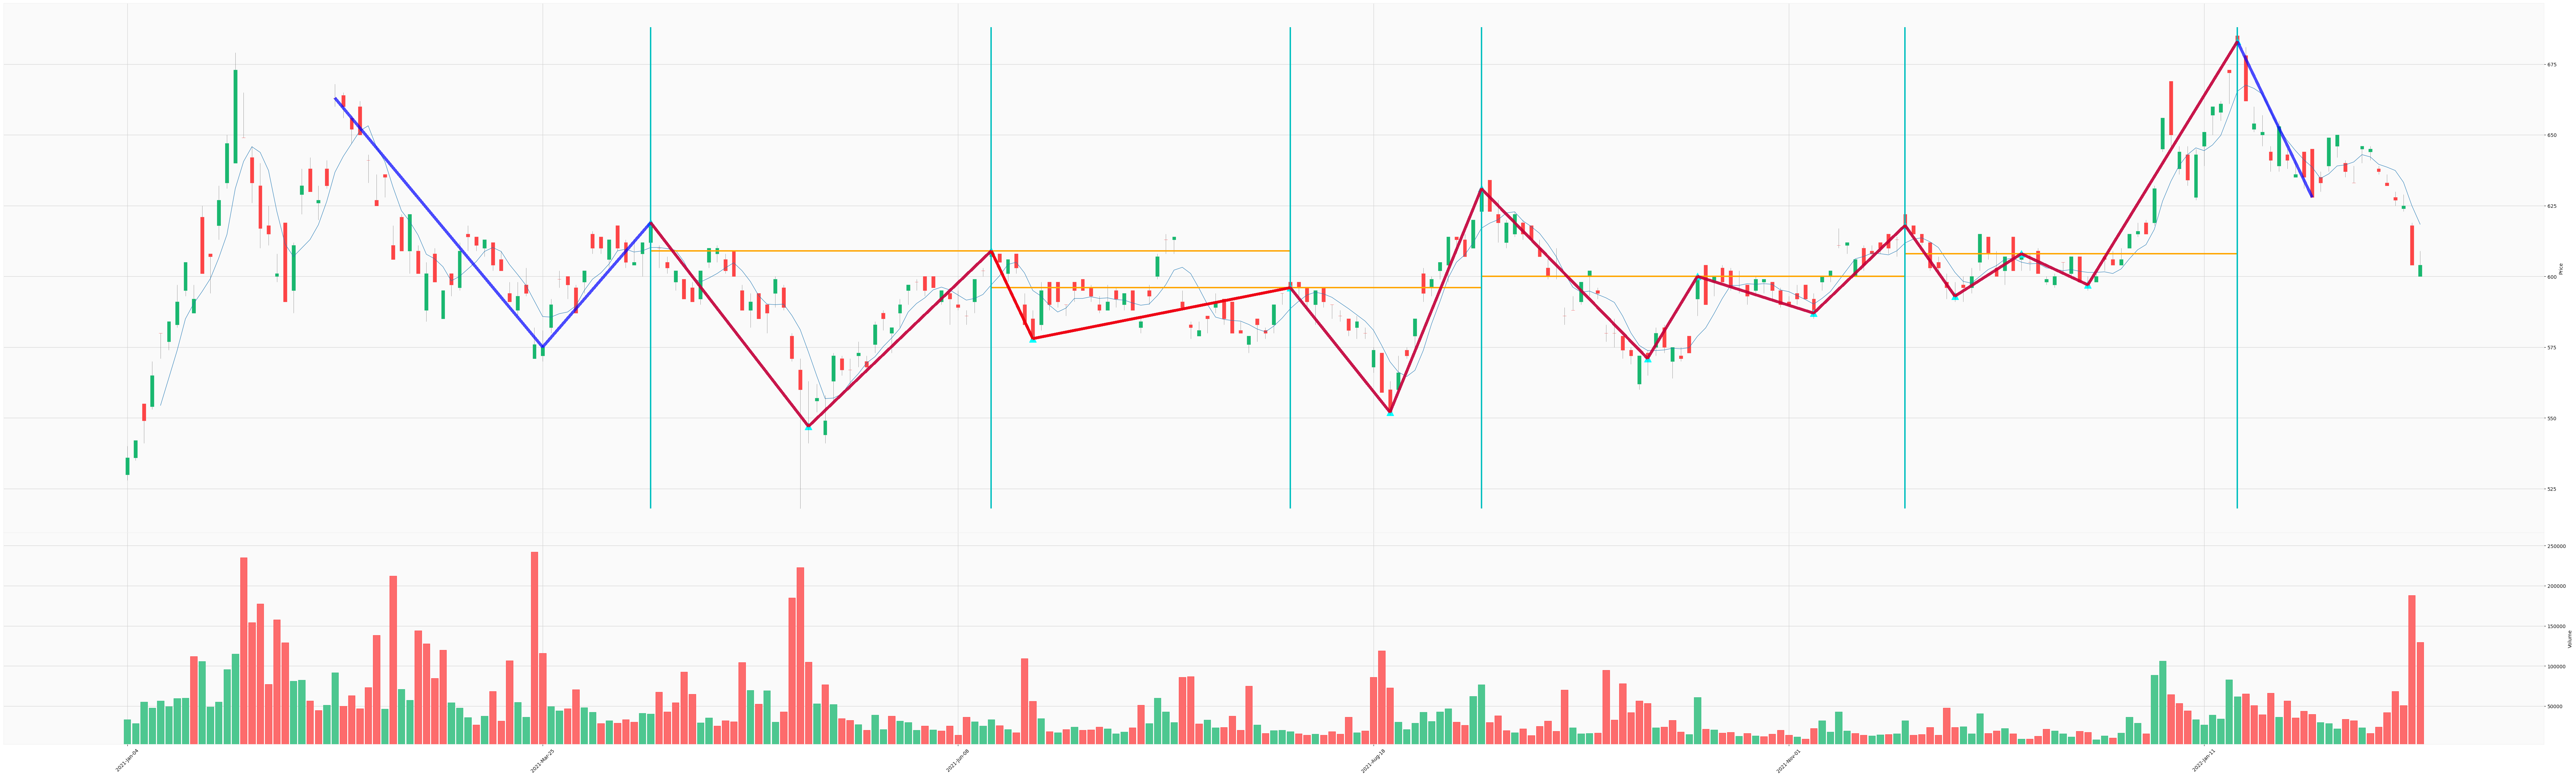

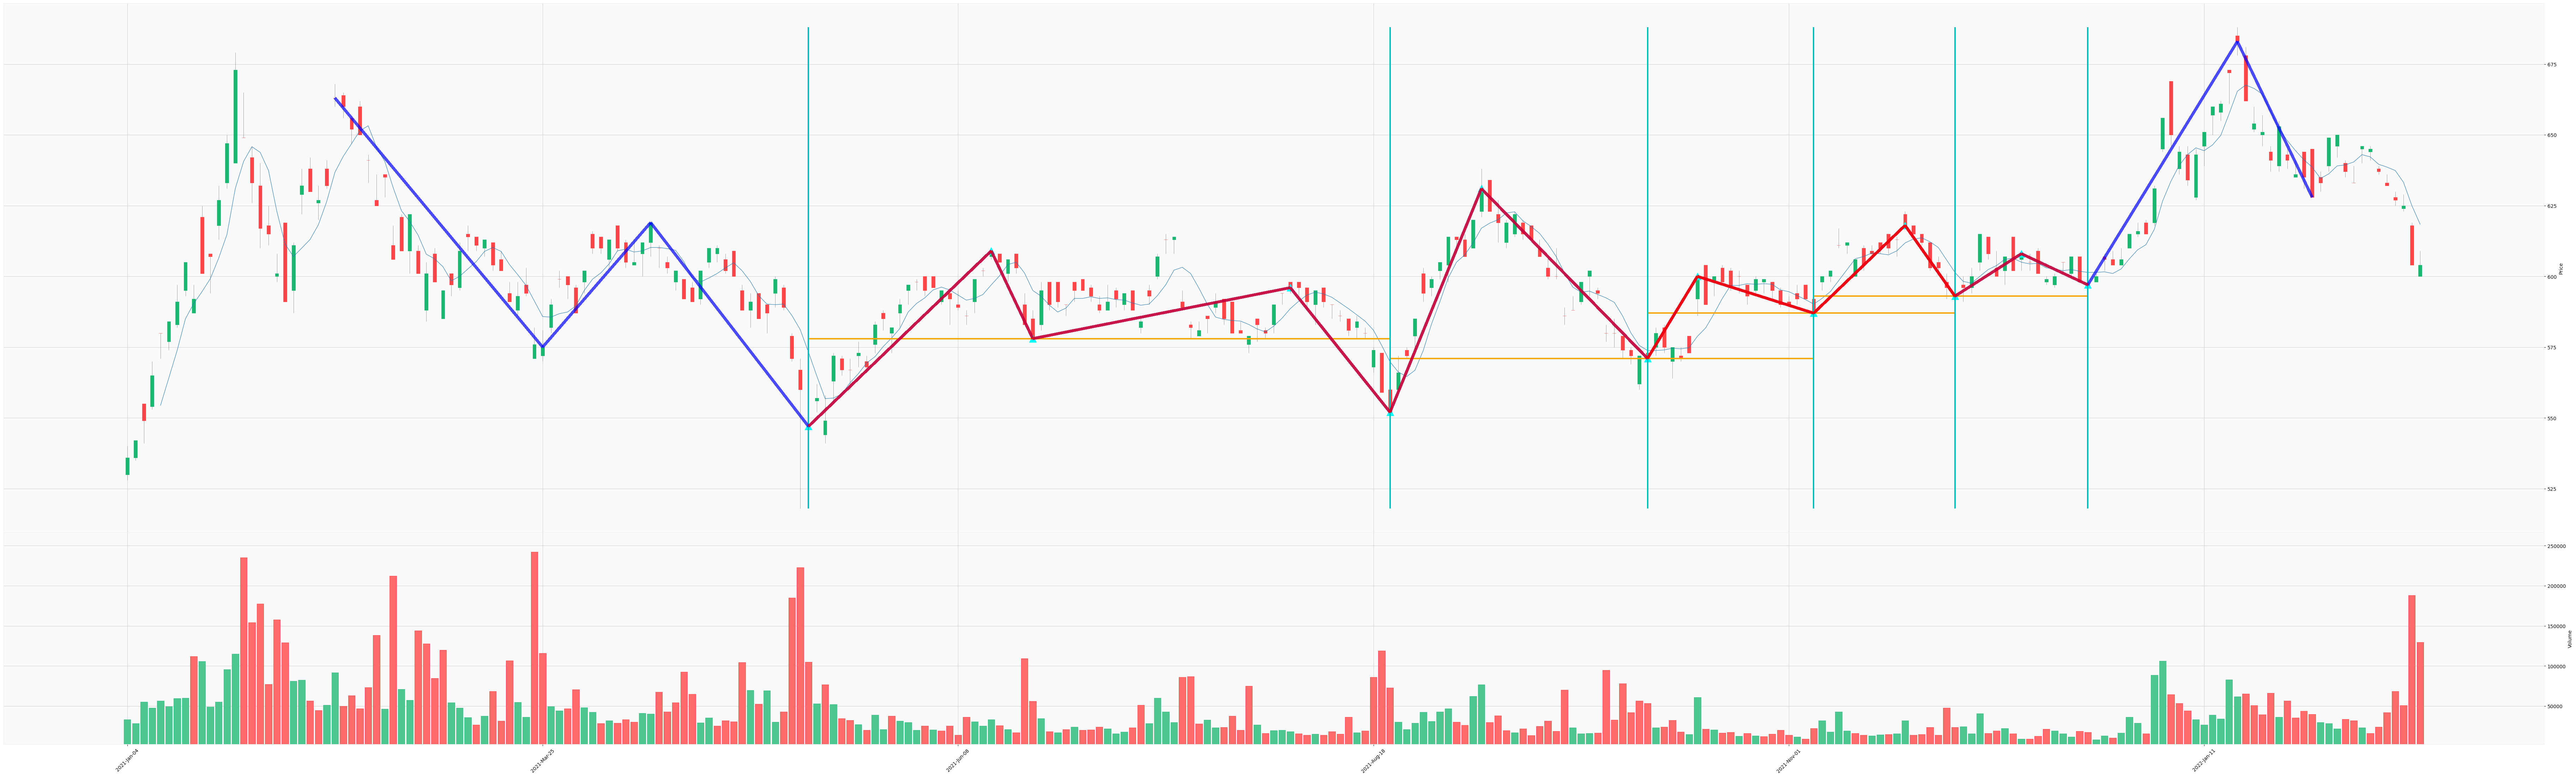

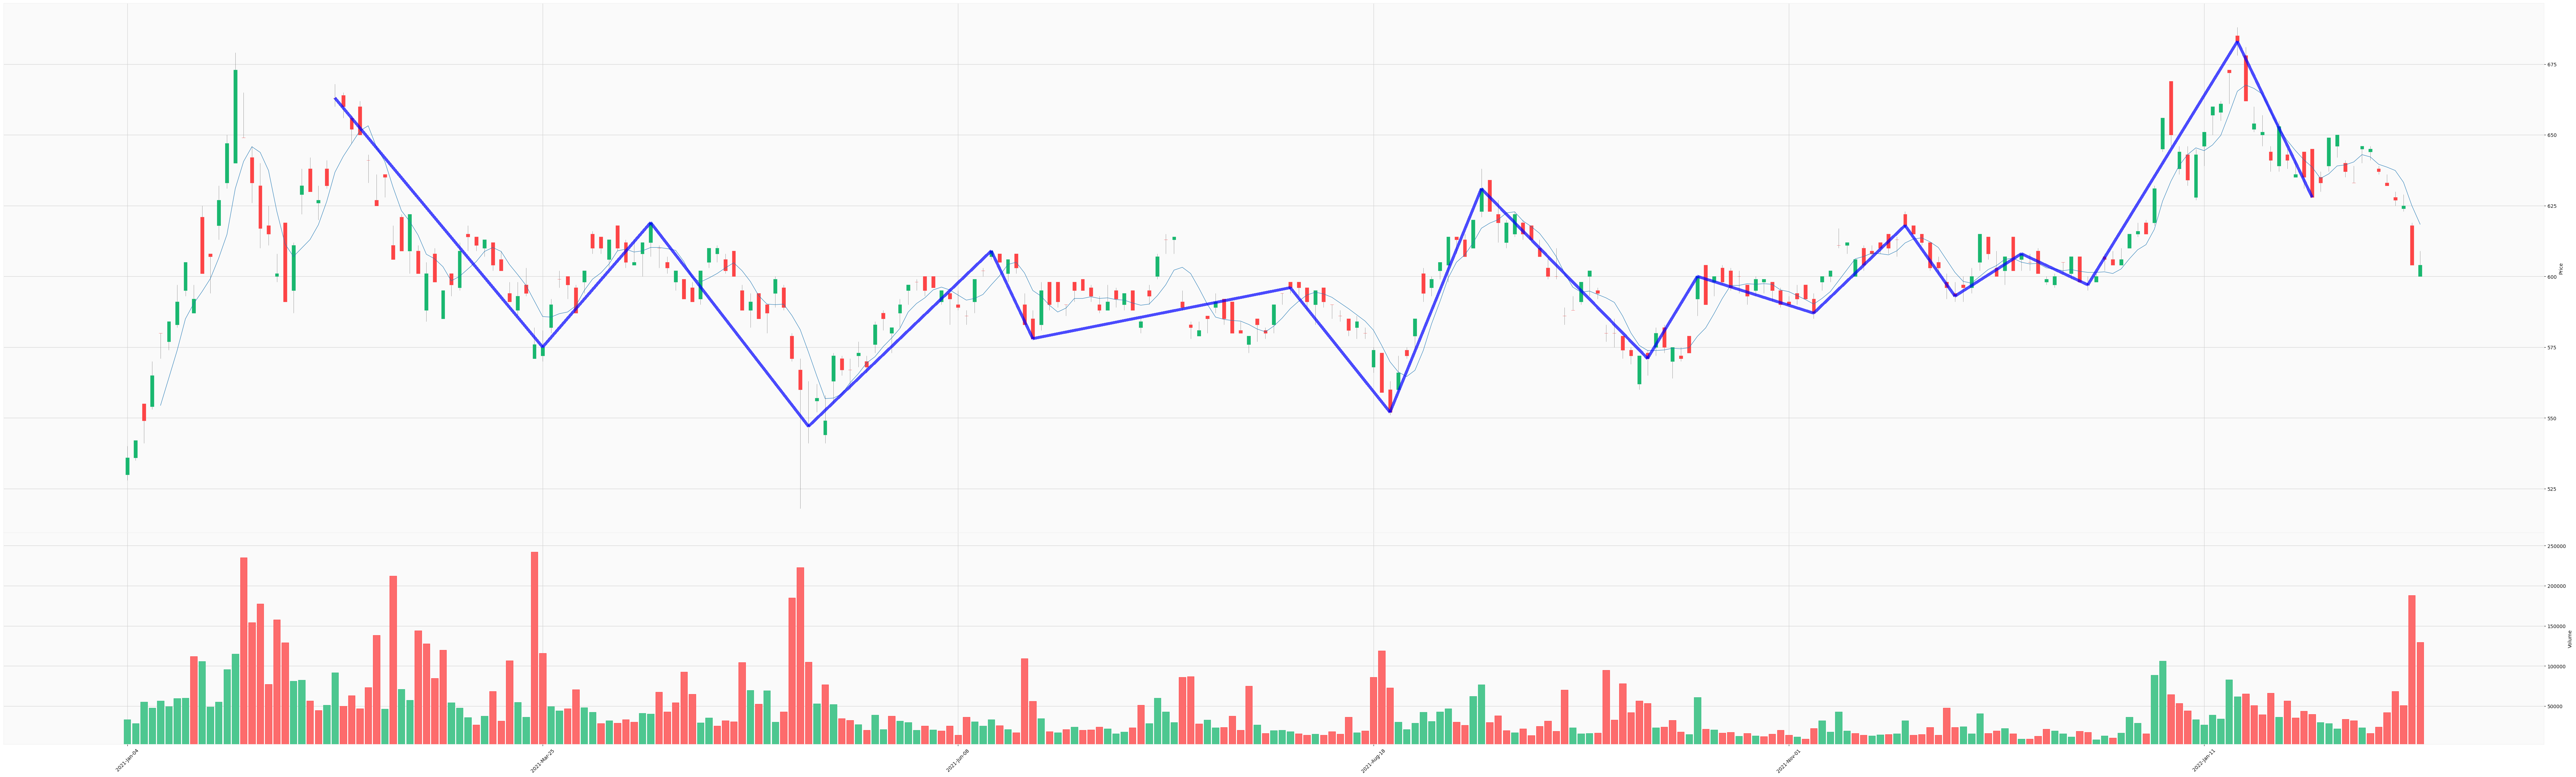

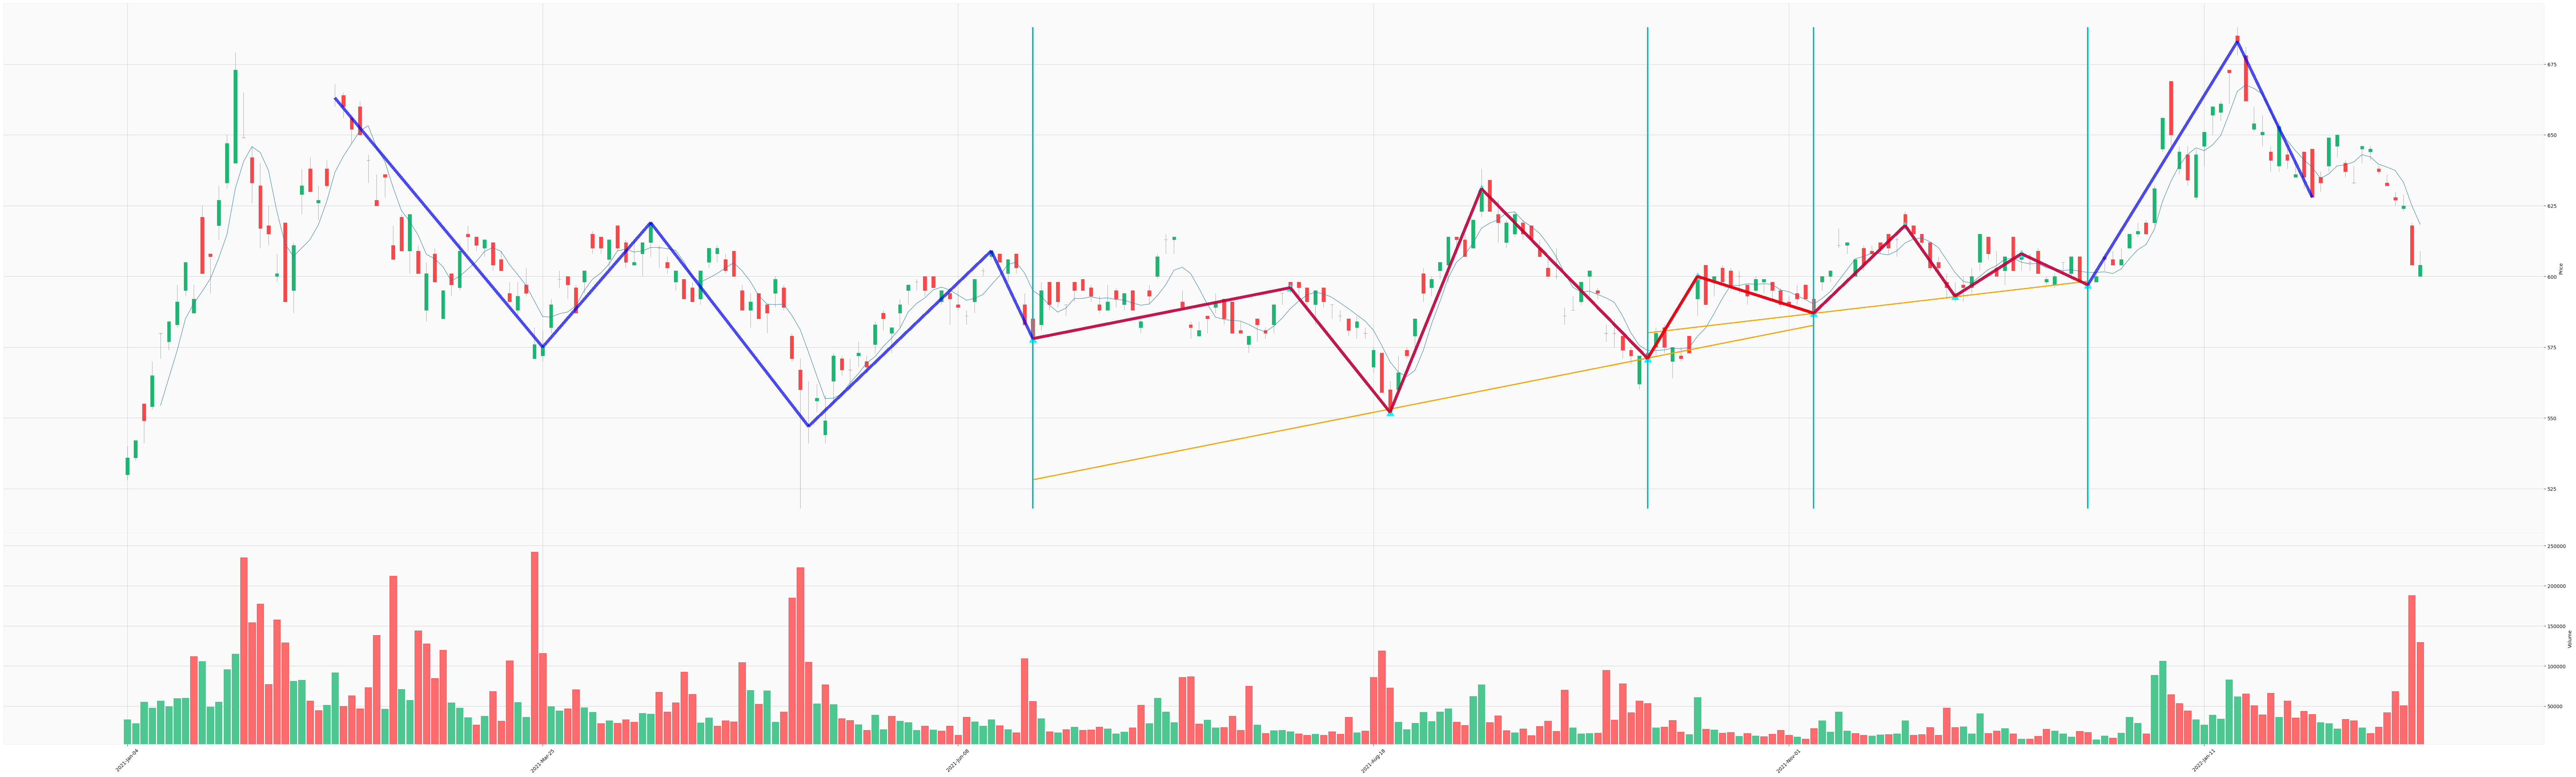

In [20]:
conn = connect_sql()
cursor = conn.cursor()

company = '2330'
day_start = '20210101'
day_end = '20220228'

#0522
df = get_data(company, day_start, day_end, cursor)
turning_wave = get_turning_wave(company, day_start, day_end, cursor)
datepairs_turning_wave = [(d1, d2) for d1, d2 in zip(turning_wave['end_day'], turning_wave['start_day'])]

'''
輸出轉折波
mpf.plot(df, type='candle', style='yahoo', mav = (5), volume = True, figsize=(100,30),
                tlines = [dict(tlines=datepairs_turning_wave, tline_use='close', colors='b', linewidths=5, alpha=0.7)])
mpf.show
'''

#0529
patterns = find_patterns(turning_wave)
#print(f'patterns["M"]: {patterns["M"]}')
#print(patterns)

plot_data = {} # note that dictionary is mutable
prepare_plot_data(df, patterns, 'W', turning_wave, plot_data)
prepare_plot_data(df, patterns, 'M', turning_wave, plot_data)
prepare_plot_data(df, patterns, 'IHS', turning_wave, plot_data)
prepare_plot_data(df, patterns, 'HS', turning_wave, plot_data)
# print(plot_data['W'])

plot_pattern('W', df, plot_data, datepairs_turning_wave)
plot_pattern('M', df, plot_data, datepairs_turning_wave)
plot_pattern('IHS', df, plot_data, datepairs_turning_wave)
plot_pattern('HS', df, plot_data, datepairs_turning_wave)